# Parameter Inference from Observed Data

In this notebook, we'll explore two methods for inferring model parameters from observed data: least squares fitting and Bayesian inference using the `bilby` package. We'll use synthetic data generated from a simple toy model with added noise to simulate measurement uncertainties.

## Generating Synthetic Data

First, we'll generate synthetic data for a falling object under gravity, which can be described by the equation:

$ y(t) = v_0 t + \frac{1}{2} g t^2 $

where $ v_0 $ is the initial velocity and $ g $ is the acceleration due to gravity.

Let's create a dataset with some added Gaussian noise to represent measurement uncertainties.


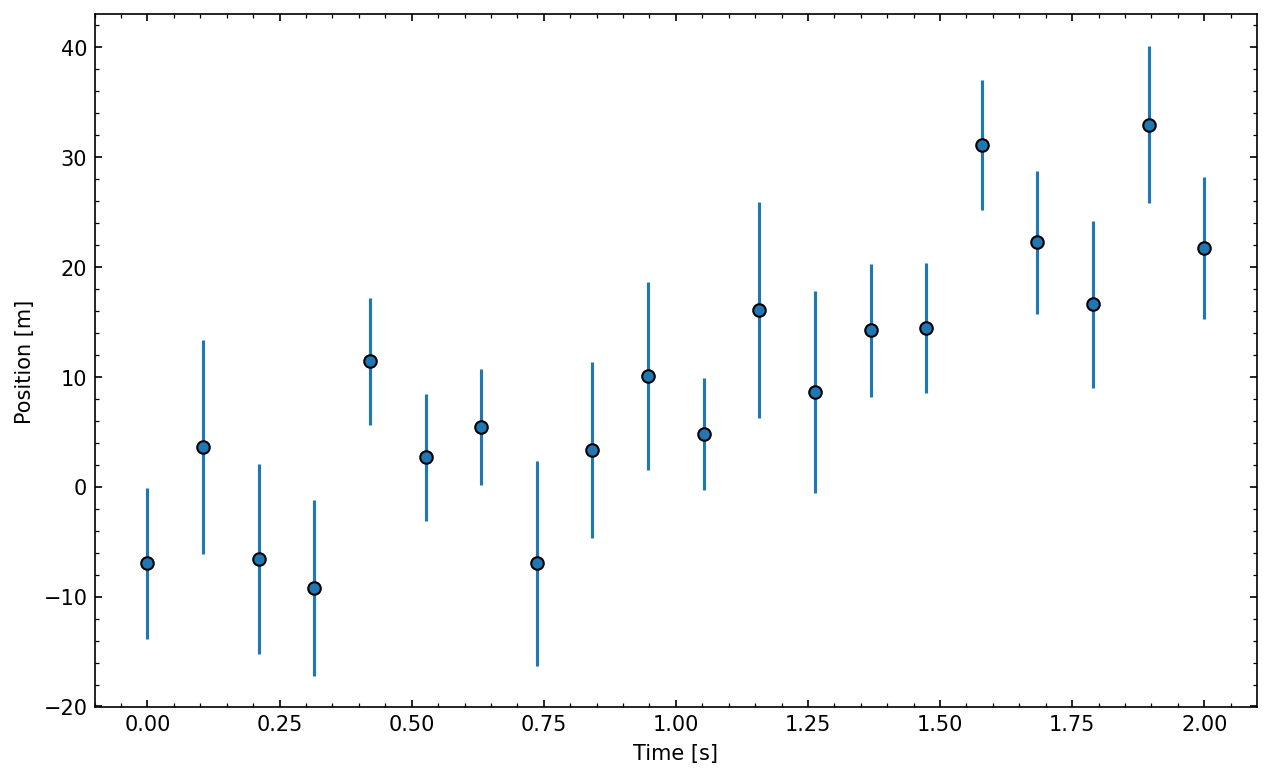

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for the true model
v0_true = 5.0  # initial velocity in m/s
g_true = 9.81  # acceleration due to gravity in m/s^2

# Generate time points
t = np.linspace(0, 2, 20)

# Generate random uncertainties for each data point
np.random.seed(42)  # For reproducibility
uncertainties = np.random.uniform(5, 10, size=t.shape)

# Generate synthetic data with noise
noise = np.random.normal(0, uncertainties)
y = v0_true * t + 0.5 * g_true * t**2 + noise
plt.figure(figsize=(10, 6), dpi=150)

# Plot the synthetic data
plt.errorbar(t, y, yerr=uncertainties, fmt='o', mec='black')
plt.xlabel('Time [s]')
plt.ylabel('Position [m]')
plt.minorticks_on()
plt.tick_params(axis='both', which='both', direction='in', top=True, right=True)
plt.show()


## Least Squares Fitting

Next, we'll perform least squares fitting to estimate the parameters $ v_0 $ and $ g $ of our model. We'll use the `curve_fit` function from `scipy.optimize`.


Fitted parameters:
 v0 = 2.228 ± 5.197
 g = 12.237 ± 6.534


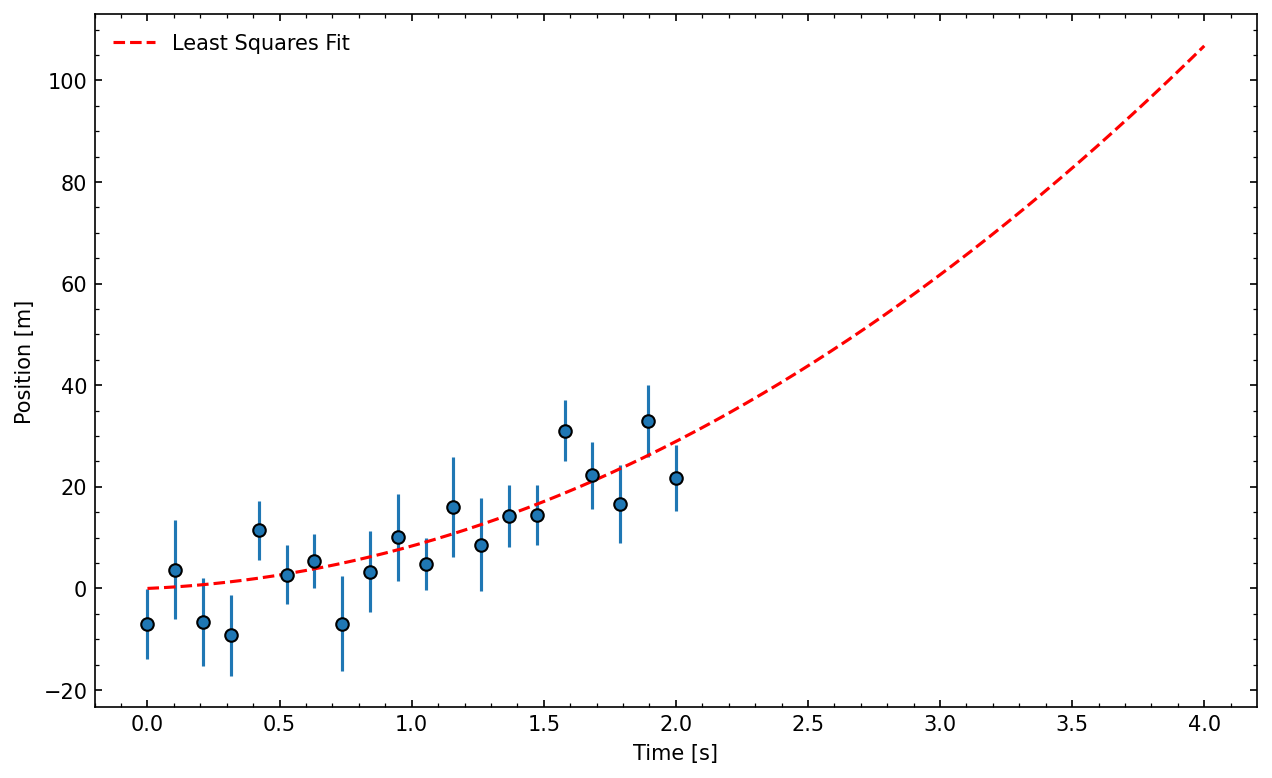

In [ ]:
from scipy.optimize import curve_fit

# Define the model function
def falling_object(t, v0, g):
    return v0 * t + 0.5 * g * t**2

# Initial guess for the parameters
initial_guess = [5.0, 10.0]

# Perform the least squares fitting
popt, pcov = curve_fit(falling_object, t, y, p0=initial_guess, sigma=uncertainties, absolute_sigma=True)

# Extract the fitted parameters and their uncertainties
v0_fit, g_fit = popt
v0_err, g_err = np.sqrt(np.diag(pcov))

print(f"Fitted parameters:\n v0 = {v0_fit:.3f} ± {v0_err:.3f}\n g = {g_fit:.3f} ± {g_err:.3f}")

# Plot the fitted model
t_fit = np.linspace(0, 4, 1000)
y_fit = falling_object(t_fit, v0_fit, g_fit)
plt.figure(figsize=(10, 6), dpi=150)

plt.errorbar(t, y, yerr=uncertainties, fmt='o', mec='black')
plt.plot(t_fit, y_fit, label='Least Squares Fit', color='red', ls='--')
plt.xlabel('Time [s]')
plt.ylabel('Position [m]')
plt.minorticks_on()
plt.tick_params(axis='both', which='both', direction='in', top=True, right=True)
plt.legend(frameon=False)
plt.show()


## Bayesian Inference using `bilby`

Now, let's use the `bilby` package to perform Bayesian inference. Bayesian inference allows us to obtain a full posterior distribution for our parameters, taking into account prior information and the likelihood of the observed data.

### Installation

First, you'll need to install `bilby`. You can install it via pip:


In [ ]:
!pip install bilby


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.3 MB/s eta 0:00:00


### Defining the Likelihood and Priors

We can now setup Bayesian Inference with `bilby` by defining a few key variables:
- Model
- Prior Distribution
- Likelihood
- nlive
- dlogz

Just like in the least squares regression case, we model the data under the functional form that we know it follows, $ y(t) = v_0 t + \frac{1}{2} g t^2 $.

We then must define a prior distribution for each of the model parameters, $v_0$ and $g$. These prior distributions are the range of values that we believe most likely contain the true parameter.

Similar to minimizing the least squares function, the liklihood is the function that we are attempting to minimize when doing bayesian inferencing. There are many kinds of liklihoods that we could use, but for this example we will use a simple Gaussian likelihood that assumes our data has gaussian errors.

Finally we must define nlive and dlogz. nlive is a parameter that sets how well we wish to explore the prior distribution. You can think about it like if you are trying to find something in a maze how many people you want to send out looking. More will result in a more thorough inference, but have higher computational cost. Meanwhile, dlogz is the fitting criteria. The smaller dlogz, the better the fit the algorithm will try to achieve before finishing, but this results in a higher computational cost.


In [ ]:
import bilby

# Define the model function to fit to your data
def falling_object(t, v0, g):
    return v0 * t + 0.5 * g * t**2

# Define the priors. These are the range of values you believe your data could have
priors = dict(
    v0=bilby.core.prior.Uniform(0, 10, 'v0'),
    g=bilby.core.prior.Uniform(0, 20, 'g')
)

# Instantiate the likelihood
likelihood = bilby.likelihood.GaussianLikelihood(t, y, falling_object, sigma=uncertainties)

# Run the sampler. This could take a while. More model parameters, the longer the fit. dloz can be changed to set the criteria of how will a fit much be before it stops running.
result = bilby.run_sampler(
    likelihood=likelihood,
    priors=priors,
    sampler='dynesty',
    nlive=500,
    dlogz=0.01,
    sample='rwalk')

11:30 bilby INFO    : Running for label 'label', output will be saved to 'outdir'
/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
11:30 bilby INFO    : Analysis priors:
11:30 bilby INFO    : v0=Uniform(minimum=0, maximum=10, name='v0', latex_label='v0', unit=None, boundary=None)
11:30 bilby INFO    : g=Uniform(minimum=0, maximum=20, name='g', latex_label='g', unit=None, boundary=None)
11:30 bilby INFO    : Analysis likelihood class: <class 'bilby.core.likelihood.GaussianLikelihood'>
11:30 bilby INFO    : Analysis likelihood noise evidence: nan
11:30 bilby INFO    : Single likelihood evaluation took nan s
11:30 bilby INFO    : Using sampler Dynesty with kwargs {'nlive': 500, 'bound': 'live', 'sample': 'rwalk', 'periodic': None, 'reflective': None, 'update_interval': 600, 'first_update': None, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool

1it [00:00, ?it/s]

11:30 bilby INFO    : Written checkpoint file outdir/label_resume.pickle
11:30 bilby INFO    : Rejection sampling nested samples to obtain 1095 posterior samples
11:30 bilby INFO    : Sampling time: 0:00:31.393768


11:30 bilby INFO    : Summary of results:
nsamples: 1095
ln_noise_evidence:    nan
ln_evidence: -67.968 +/-  0.051
ln_bayes_factor:    nan +/-  0.051



### We can plot a corner plot to show the distributions of the predicted parameters (posteriors) and the correlation between them. On each histogram the most likely value and 1$\sigma$ error bars are labeled.

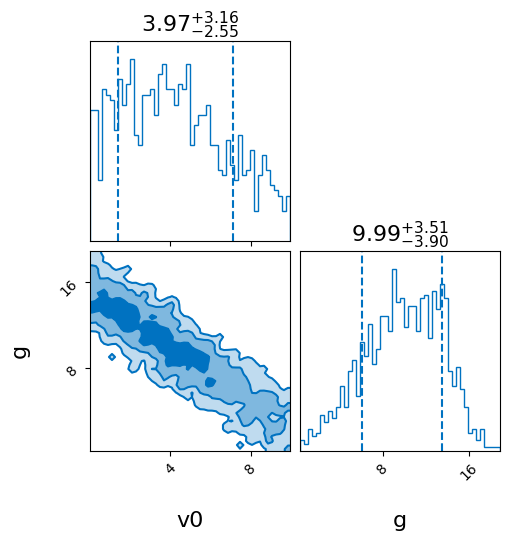

In [ ]:
result.plot_corner()


### We can directly compare the prediced model fit to the observed data to determine by eye whether or not our fit converged to something reasonable.

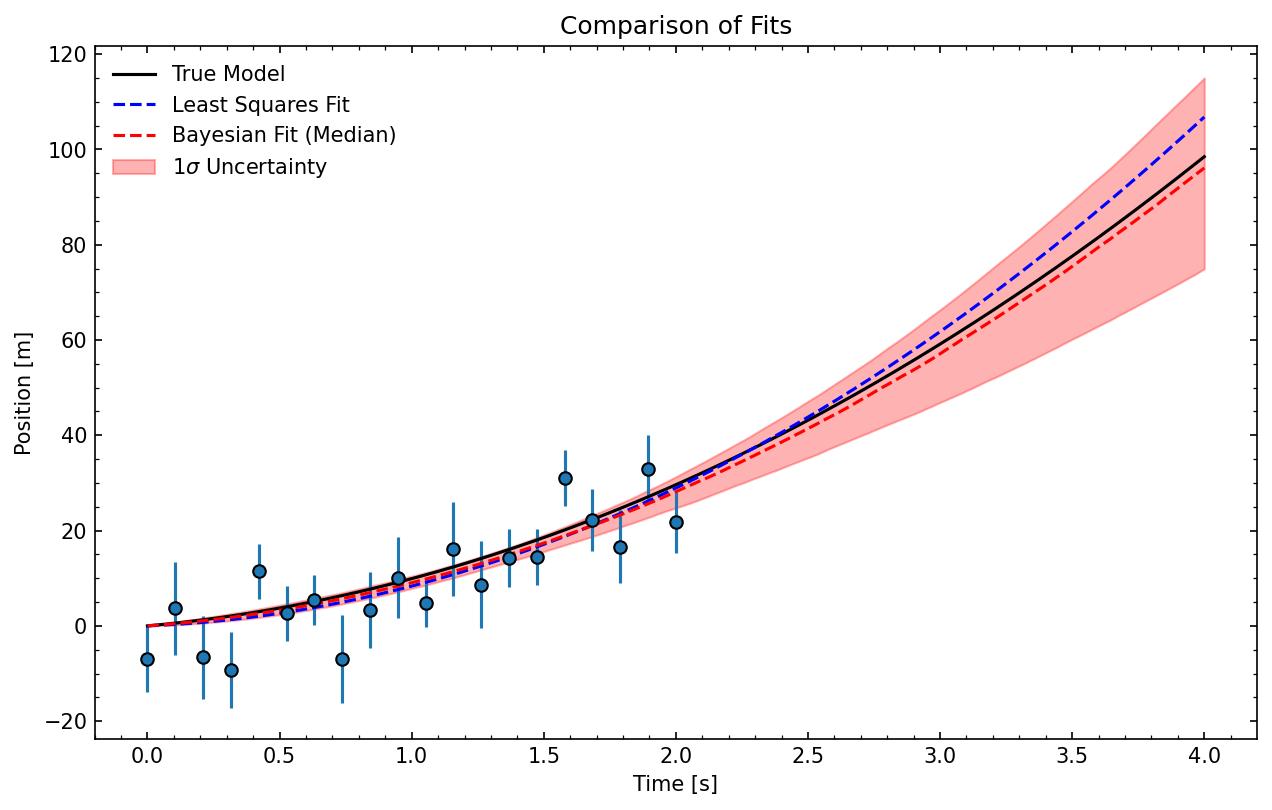

In [ ]:
# Extract the posterior samples
samples = result.posterior
v0_samples = samples['v0']
g_samples = samples['g']

# Compute the model predictions for a range of parameter samples
t_fit = np.linspace(0, 4, 1000)
y_samples = np.array([falling_object(t_fit, v0, g) for v0, g in zip(v0_samples, g_samples)])

# Compute the 16th, 50th, and 84th percentiles for the model predictions
y_median = np.percentile(y_samples, 50, axis=0)
y_lower = np.percentile(y_samples, 16, axis=0)
y_upper = np.percentile(y_samples, 84, axis=0)

plt.figure(figsize=(10, 6), dpi=150)
# Plot the data, the true model, the least squares fit, and the Bayesian inference results
plt.errorbar(t, y, yerr=uncertainties, fmt='o', mec='black')
plt.plot(t_fit, v0_true * t_fit + 0.5 * g_true * t_fit**2, label='True Model', color='black')
plt.plot(t_fit, y_fit, label='Least Squares Fit', color='blue', ls='--')
plt.plot(t_fit, y_median, label='Bayesian Fit (Median)', color='red', ls='--')
plt.fill_between(t_fit, y_lower, y_upper, color='red', alpha=0.3, label=r'1$\sigma$ Uncertainty')
plt.xlabel('Time [s]')
plt.ylabel('Position [m]')
plt.title('Comparison of Fits')
plt.minorticks_on()
plt.tick_params(axis='both', which='both', direction='in', top=True, right=True)
plt.legend(frameon=False)
plt.show()

### As you can see, sampling methods like MCMC provide much more robust estimates of parameters and their uncertainties than traditional methods such as least squares regression. This becomes particularly important as you move towards fitting more and more complicated models.

# Activity

### Using any dataset of your choosing (kaggle is a great resource. Alternatively you could try simulating some data like was done in the example), define a model that you think would describe the system and attempt to fit it to the data using both least squares with scipy curve fit and MCMC with bilby.

### Make a corner plot and plot the predicted fits from least squares and curve fit on the observed data as was done in the example.

### Your model does not need to be complex or hold any physical significance. It could be as simple as fitting a polynomial. Just try to pick a model that seems like it would fit the data well. Ultimately the point of this is to get you comforatable with fitting data. It is one of the most important fundamental skills in research.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
!pip install bilby
import bilby


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.6 MB/s eta 0:00:00


<Figure size 1500x900 with 0 Axes>

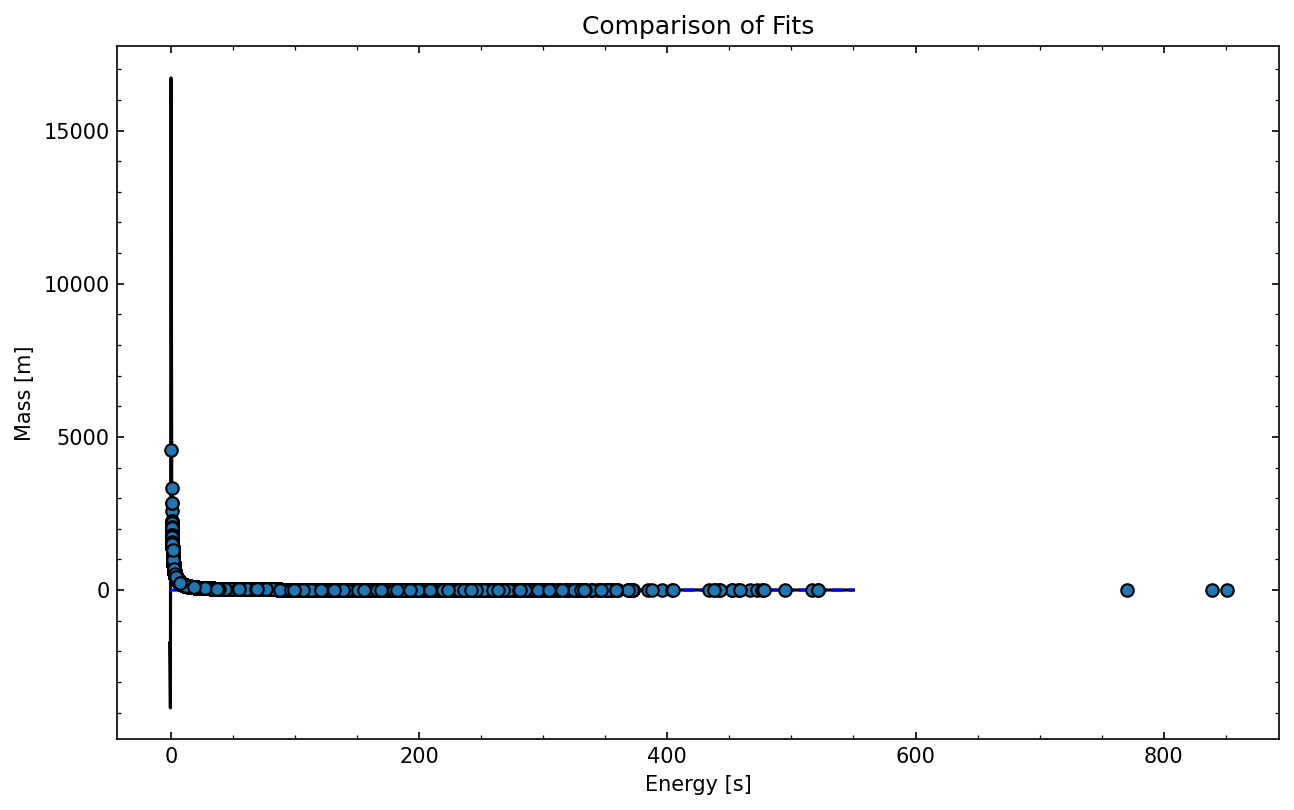

In [ ]:
dielectron = pd.read_csv('dielectron.csv')

# True model function
px1_true = dielectron.iloc[0,3]
py1_true = dielectron.iloc[0,4]
pz1_true = dielectron.iloc[0,5]
p1squared_true = ((px1_true**2)+(py1_true**2)+(pz1_true**2))
E1 = dielectron.iloc[:,2]

# Generate synthetic data

m = p1squared_true/(2*E1)
plt.figure(figsize=(10, 6), dpi=150)

# model function

def mass1(p1_squared, E1):
    return p1_squared/(2*E1)

# Initial guess for the parameters
p1_squared_guess = (px1_true**2)+(py1_true**2)+(pz1_true**2)
initial_guess = [p1_squared_guess]

# Perform the least squares fitting
popt, pcov = curve_fit(mass1, E1, m, p0=initial_guess)

# Extract the fitted parameters and their uncertainties
#px1_fit, py1_fit, pz1_fit = popt
p1_squared_fit = popt
#px1_err, py1_err, pz1_err = np.sqrt(np.diag(pcov))
p1_squared_err = np.sqrt(np.diag(pcov))

# Priors
#priors = dict(p1_squared=bilby.core.prior.Uniform(0, 40, 'E1'))

# Likelihood
#likelihood = bilby.likelihood.GaussianLikelihood(E1, m, mass1)

# Sampler
#result = bilby.run_sampler(likelihood=likelihood, priors=priors, sampler='dynesty', nlive=500, dlogz=0.01, sample='rwalk')

# Posterior samples
#samples = result.posterior
#p1_squared_samples = samples['p1_squared']

# Model predictions for a range of parameter samples

#E1_fit = np.linspace(1, 550, 1000)
#m_samples = np.array([mass1(p1_squared,E1_fit) for p1_squared in zip(p1_squared_samples)])

# Compute the 16th, 50th, and 84th percentiles for the model predictions
#m_med = np.percentile(m_samples, 50, axis=0)
#m_low = np.percentile(m_samples, 16, axis=0)
#m_upp = np.percentile(m_samples, 84, axis=0)

# Plot the model
E1_fit = np.linspace(-1, 550, 1000)
m_fit = mass1(p1_squared_fit, E1_fit)
plt.figure(figsize=(10, 6), dpi=150)

plt.errorbar(E1, m, fmt='o', mec='black')
plt.plot(E1_fit, p1squared_true/(2*E1_fit) , label='True Model', color='black')
plt.plot(E1_fit, m_fit, label='Least Squares Fit', color='blue', ls='--')
#plt.plot(E1_fit, m_med, label='Bayesian Fit (Median)', color='red', ls='--')
#plt.fill_between(E1_fit, m_low, m_upp, color='red', alpha=0.3, label=r'1$\sigma$ Uncertainty')
plt.xlabel('Energy [s]')
plt.ylabel('Mass [m]')
plt.title('Comparison of Fits')
plt.minorticks_on()
plt.tick_params(axis='both', which='both', direction='in', top=True, right=True)
plt.show()



